# High Influx filter

This notebook shows the “HI_filter” to detect unrealistically high rainfall rainfall amounts reported by a PWS compared with a reference. 
The original R code stems from https://github.com/LottedeVos/PWSQ

In [2]:
# Import packages

import numpy as np
import xarray as xr
import poligrain as plg
import matplotlib.pyplot as plt

## Load example data
[short description of example data]

In [41]:
# download nc file to current directory. Does not work to read data if I do this, only if I download manually from github (get ValueError)
# !curl -OL https://github.com/OpenSenseAction/OS_data_format_conventions/tree/main/notebooks/data/OpenSense_PWS_example_format_data.nc

In [42]:
#test = xr.open_dataset("OpenSense_PWS_example_format_data.nc")
#test

# old file:
# !curl -OL https://github.com/OpenSenseAction/training_school_opensene_2023/raw/main/data/pws/data_PWS_netCDF_AMS_float.nc

In [3]:
# read PWS data with xarray
ds_pws = xr.open_dataset("C:/Users/a002461/OPENSENSE/data/OpenSense_PWS_example_format_data.nc")  
#ds_pws = ds_pws.load() # do here already? 

#rename to follow opensense naming convention
ds_pws = ds_pws.rename_vars({"longitude": "lon", "latitude": "lat"} )

#slice to time of interest (remove)
#ds_pws = ds_pws.sel(time=slice("2017-09-13 00:00:00", "2017-09-13 03:00"))

ds_pws

<xarray.Dataset> Size: 119MB
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2MB 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 3kB 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 2kB ...
    lat        (id) float64 1kB ...
    lon        (id) float64 1kB ...
Data variables:
    rainfall   (id, time) float32 117MB ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

In [11]:
#ds_pws.rainfall.cumsum(dim="time").plot.line(x="time", add_legend=False, linewidth=0.5);

## Set parameters

See table 1 in https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731

In [4]:
d = 10e3  #range around each station, meters
nstat = 5 #threshold for nr of stations within range d reporting data

## Create distance matrix

[Preparations below both apply to HI and FZ filter. Apply poligrain here]


### Reproject coordinates to metric projection to allow for distance calculations 

In [5]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(x=ds_pws.lon, y=ds_pws.lat, target_projection="EPSG:25832")

### Calculate distance between all stations of the network in meters

In [6]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)
#create a sparse matrix --> to be applicable for large datasets 

#distance_matrix.to_netcdf('C:/Users/a002461/OPENSENSE/data/distance_matrix.nc')

## Check if QC filters can be applied

In [7]:
%%time 

ds_pws = ds_pws.load()
nbrs_not_nan= []

for pws_id in ds_pws.id.data:
    neighbor_ids = distance_matrix.id.data[distance_matrix.sel(id=pws_id) < d]
    N = ds_pws.rainfall.sel(id=neighbor_ids).isnull().sum(dim="id")
    nbrs_not_nan.append(N)

Wall time: 6.48 s


In [8]:
ds_pws["nbrs_not_nan"] = xr.concat(nbrs_not_nan, dim = "id")

In [9]:
#assign -1 if less than nstat neighbours - QC filters cannot be applied to these observations
ds_pws["HIflag"]= xr.where(ds_pws.nbrs_not_nan < nstat, -1,0)
ds_pws["FZflag"]= xr.where(ds_pws.nbrs_not_nan < nstat, -1,0)

Text(0.5, 1.0, 'Filter cannot be applied')

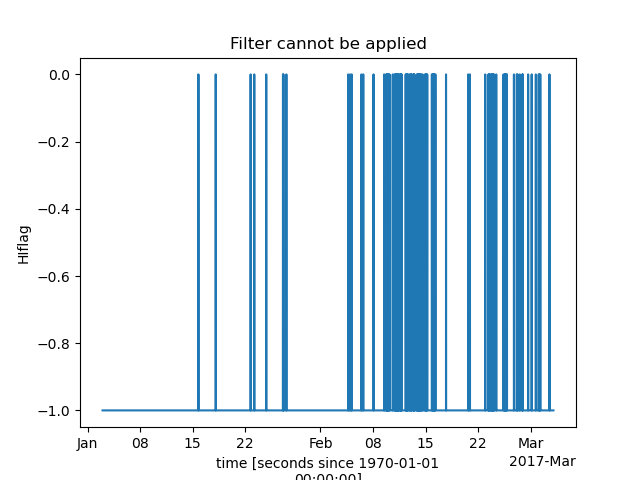

In [18]:
%matplotlib widget

id = 'ams2'

fig,ax = plt.subplots()

ds_pws.HIflag.sel(id=id,time=slice("2017-01-03 00:00:00", "2017-03-04 00:00")).plot() #time=slice("2017-01-03 00:00:00", "2017-03-04 00:00"
plt.title("Filter cannot be applied")

## Calculate reference

The default reference of the filter is to compare the observed rainfall of a given station with the median rainfall from all stations within a range `d`. If the median is below the threshold value `HIthresA`, the HI flag for the station is set to 1 (i.e. high influx) for rainfall amounts above threshold `HIthresB`. When the surrounding stations report moderate to heavy rainfall, the threshold becomes variable: for a median of `HIthresA` or higher, the station's HI flag is set to 1 when its measurements exceed the median times `HIthresB/HIthresA`. 

_Allow for other metrics in addition to median? Stochastic methods? Propose other metrics for variable_ `reference`? Compare with secondary data?

In [13]:
%%time

reference = []

for pws_id in ds_pws.id.data:
    neighbor_ids = distance_matrix.id.data[distance_matrix.sel(id=pws_id) < d]
    median = ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id")
    reference.append(median)

Wall time: 18.6 s


In [14]:
ds_pws["reference"] = xr.concat(reference, dim="id") 
ds_pws

<xarray.Dataset> Size: 589MB
Dimensions:       (time: 219168, id: 134)
Coordinates:
  * time          (time) datetime64[ns] 2MB 2016-05-01T00:05:00 ... 2018-06-01
  * id            (id) <U6 3kB 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'
    elevation     (id) <U3 2kB 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan'
    lat           (id) float64 1kB 52.31 52.3 52.31 52.35 ... 52.43 52.3 52.26
    lon           (id) float64 1kB 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
    x             (id) float64 1kB 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y             (id) float64 1kB 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall      (id, time) float32 117MB 0.0 0.0 0.0 0.0 ... nan 0.0 0.0 0.0
    nbrs_not_nan  (id, time) int32 117MB 8 8 8 8 8 8 8 8 ... 9 10 10 9 10 9 9 9
    HIflag        (id, time) int32 117MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    FZflag        (id, time) int32 117MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    reference     (id, time) float32 117MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

## Faulty Zeroes filter

## High Influx filter

Conditions for raising High Influx flag:
* HIflag is not -1
* If median below threshold ϕA, then high influx if rainfall above threshold ϕB
* If median above ϕA, then high influx if rainfall exceeds median times ϕB/ϕA

In [20]:
HIthresA = 0.2  # threshold for median rainfall of stations within range d, mm
HIthresB = 0.4  # upper rainfall limit, mm.

#ds_pws["HIflag"] = pypwsqc.HI_filter(ds_pws.rainfall, distance_matrix, reference, HIthresA, HIthresB)


In [ ]:
condition1 = (ds_pws.HIflag != -1) 
condition2 = (ds_pws.reference < HIthresA) & (ds_pws.rainfall > HIthresB) 
condition3 = (ds_pws.reference >= HIthresA) & (ds_pws.rainfall > ds_pws.reference * HIthresB / HIthresA ) 

ds_pws["HIflag"]= xr.where(condition1 & (condition2 | condition3), 1, 0)
ds_pws

In [16]:
condition1 = (ds_pws.HIflag != -1) 

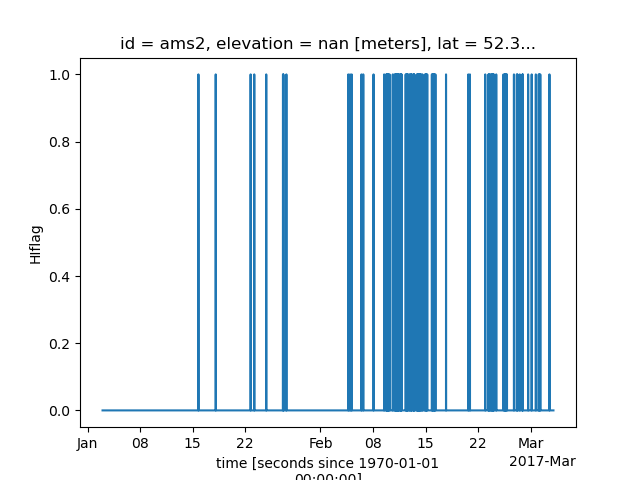

In [19]:
%matplotlib widget

id = 'ams2'

fig,ax = plt.subplots()
plt.title("condition1")

condition1.sel(id=id,time=slice("2017-01-03 00:00:00", "2017-03-04 00:00")).plot() #,time=slice("2017-01-03 00:00:00", "2017-03-04 00:00")

In [21]:
condition2 = ((ds_pws.reference < HIthresA) & (ds_pws.rainfall > HIthresB))

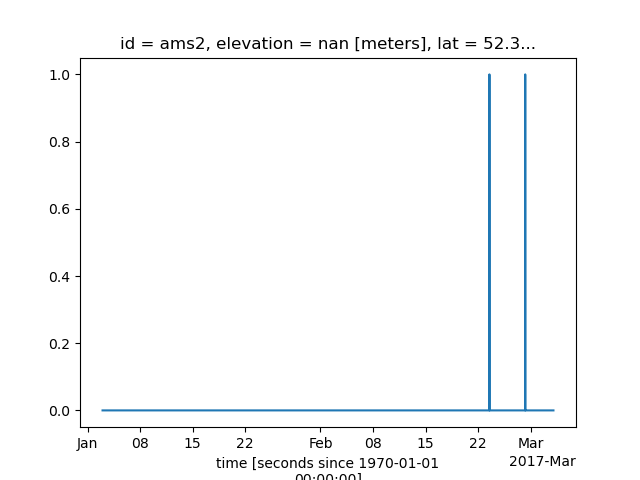

In [22]:
%matplotlib widget

id = 'ams2'

fig,ax = plt.subplots()
plt.title("condition1")

condition2.sel(id=id,time=slice("2017-01-03 00:00:00", "2017-03-04 00:00")).plot()

In [23]:
condition3 = (ds_pws.reference >= HIthresA) & (ds_pws.rainfall > ds_pws.reference * HIthresB / HIthresA ) 

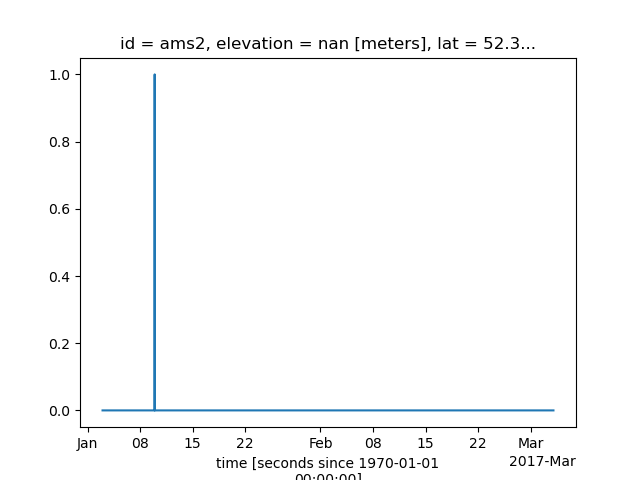

In [24]:
%matplotlib widget

id = 'ams2'

fig,ax = plt.subplots()
plt.title("condition1")

condition3.sel(id=id,time=slice("2017-01-03 00:00:00", "2017-03-04 00:00")).plot()

In [27]:
condition1 = (ds_pws.HIflag != -1) 
condition2 = (ds_pws.reference < HIthresA) & (ds_pws.rainfall > HIthresB) 
condition3 = (ds_pws.reference >= HIthresA) & (ds_pws.rainfall > ds_pws.reference * HIthresB / HIthresA ) 

ds_pws["HIflag"]= xr.where(condition1 & (condition2 | condition3), 1, 0)
ds_pws

<xarray.Dataset> Size: 589MB
Dimensions:       (time: 219168, id: 134)
Coordinates:
  * time          (time) datetime64[ns] 2MB 2016-05-01T00:05:00 ... 2018-06-01
  * id            (id) <U6 3kB 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'
    elevation     (id) <U3 2kB 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan'
    lat           (id) float64 1kB 52.31 52.3 52.31 52.35 ... 52.43 52.3 52.26
    lon           (id) float64 1kB 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
    x             (id) float64 1kB 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y             (id) float64 1kB 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall      (id, time) float32 117MB 0.0 0.0 0.0 0.0 ... nan 0.0 0.0 0.0
    nbrs_not_nan  (id, time) int32 117MB 8 8 8 8 8 8 8 8 ... 9 10 10 9 10 9 9 9
    HIflag        (id, time) int32 117MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    FZflag        (id, time) int32 117MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    reference     (id, time) float32 117MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

Text(0.5, 1.0, 'Applied HI filter')

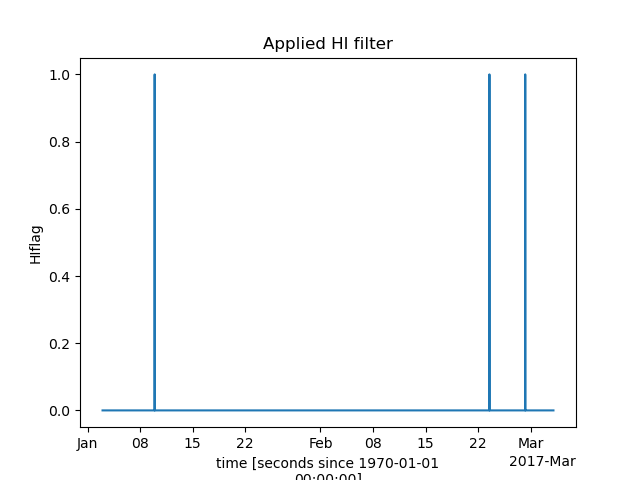

In [28]:
%matplotlib widget

id = 'ams2'

fig,ax = plt.subplots()

ds_pws.HIflag.sel(id=id,time=slice("2017-01-03 00:00:00", "2017-03-04 00:00")).plot()
plt.title("Applied HI filter")

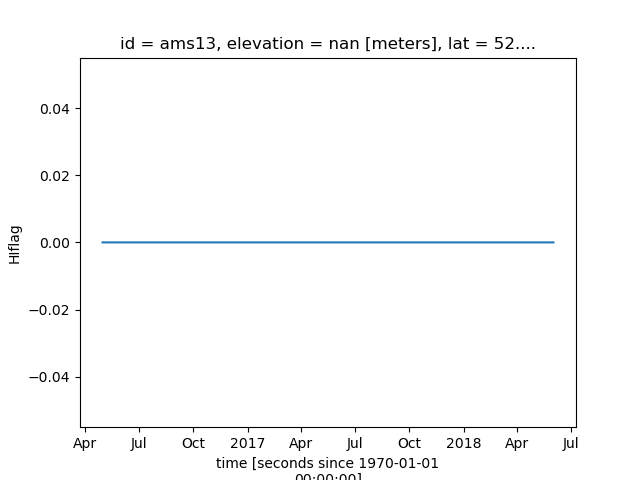

In [48]:
%matplotlib widget

id = 'ams13'

fig,ax = plt.subplots()

#condition1.sel(id = id).plot()
ds_pws.HIflag.sel(id = id).plot()

In [ ]:
condition1 = (ds_pws.HIflag != -1) 
condition2 = (ds_pws.reference < HIthresA) & (ds_pws.rainfall > HIthresB) 
condition3 = (ds_pws.reference >= HIthresA) & (ds_pws.rainfall > ds_pws.reference * HIthresB / HIthresA ) 

ds_pws["HIflag"]= xr.where(condition1 & (condition2 | condition3), 1, 0)
ds_pws

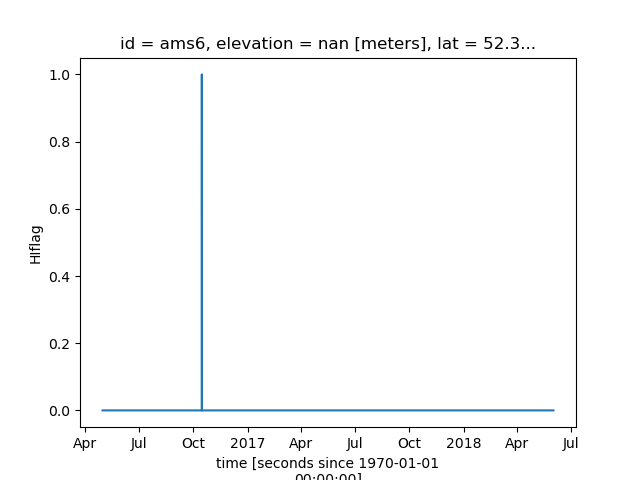

In [35]:
%matplotlib widget

id = 'ams6'

fig,ax = plt.subplots()

ds_pws.HIflag.sel(id = id).plot()
#ds_pws.HIflag.sel(id=id,time=slice("2017-01-03 00:00:00", "2017-03-04 00:00")).plot()


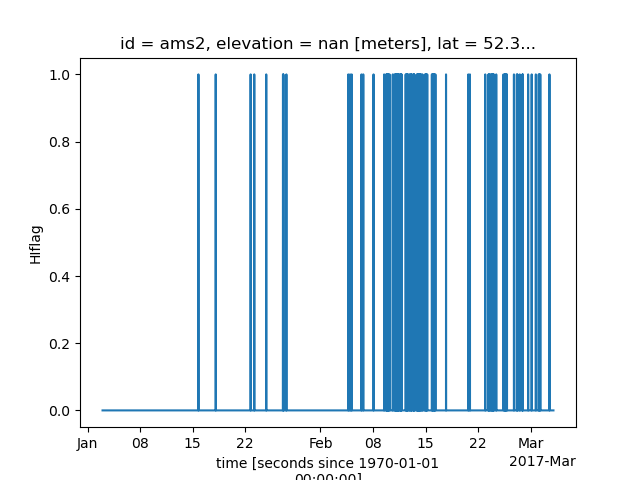

In [31]:
%matplotlib widget

id = 'ams2'

fig,ax = plt.subplots()

#ds_pws.reference.sel(id=id).plot(ax=axs[0])
condition1.sel(id=id,time=slice("2017-01-03 00:00:00", "2017-03-04 00:00")).plot()


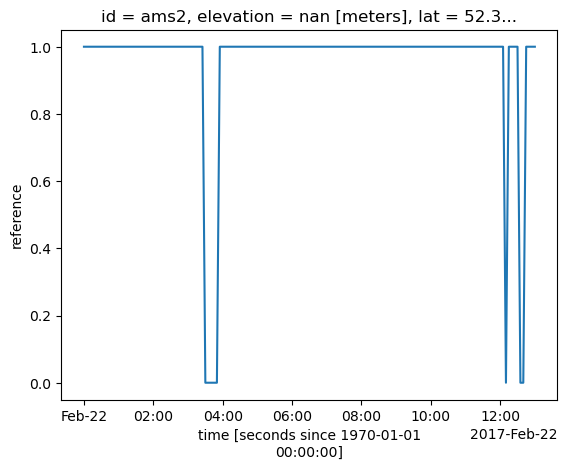

In [42]:
id = "ams2" #for ams 2 the median was above 0.2 mm at 12:00 on Feb 22 2017

HIthresA = 0.2
HIthresB = 0.5

condition2 = (ds_pws.reference < HIthresA) #((ds_pws.reference < HIthresA) & (ds_pws.rainfall > HIthresB))
condition2

condition2.sel(id=id, time=slice("2017-02-22 00:00:00", "2017-02-22 13:00")).plot()

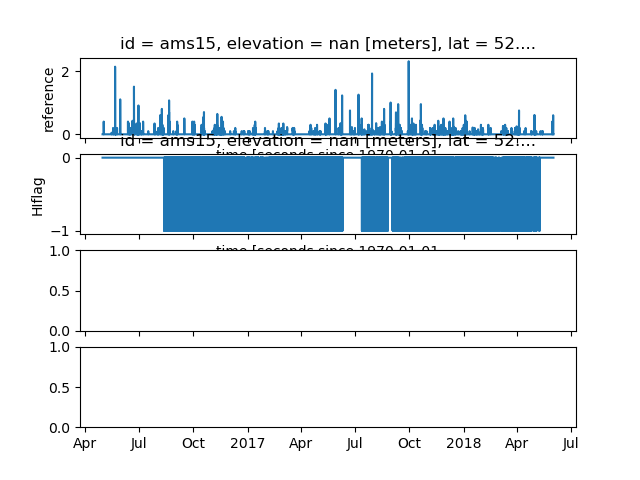

In [14]:
%matplotlib widget

id = 'ams15'

fig, axs = plt.subplots(4, 1, sharex=True)
fig,ax = plt.subplots()

ds_pws.reference.sel(id=id).plot(ax=axs[0])
ds_pws.HIflag.sel(id=id).plot(ax=axs[1])

#condition1.sel(id=id, time=slice("2017-01-03 00:00:00", "2017-03-04 00:00")).plot(ax=axs[1])

#ds_pws.reference.plot()

In [46]:
ds_pws.HIflag

<xarray.DataArray 'HIflag' (id: 134, time: 219168)> Size: 117MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * time       (time) datetime64[ns] 2MB 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 3kB 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 2kB 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    lat        (id) float64 1kB 52.31 52.3 52.31 52.35 ... 52.43 52.3 52.26
    lon        (id) float64 1kB 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
    x          (id) float64 1kB 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 1kB 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06

In [24]:
condition1 = (ds_pws.HIflag != -1) 
condition2 = (ds_pws.reference < HIthresA) & (ds_pws.rainfall > HIthresB) 
condition3 = (ds_pws.reference >= HIthresA) & (ds_pws.rainfall > ds_pws.reference * HIthresB / HIthresA ) 

ds_pws["HIflag"]= xr.where(condition1 & (condition2 | condition3), 1, 0)
ds_pws

<xarray.Dataset> Size: 589MB
Dimensions:       (time: 219168, id: 134)
Coordinates:
  * time          (time) datetime64[ns] 2MB 2016-05-01T00:05:00 ... 2018-06-01
  * id            (id) <U6 3kB 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'
    elevation     (id) <U3 2kB 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan'
    lat           (id) float64 1kB 52.31 52.3 52.31 52.35 ... 52.43 52.3 52.26
    lon           (id) float64 1kB 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
    x             (id) float64 1kB 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y             (id) float64 1kB 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall      (id, time) float32 117MB 0.0 0.0 0.0 0.0 ... nan 0.0 0.0 0.0
    nbrs_not_nan  (id, time) int32 117MB 8 8 8 8 8 8 8 8 ... 9 10 10 9 10 9 9 9
    HIflag        (id, time) int32 117MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    FZflag        (id, time) int32 117MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    reference     (id, time) float32 117MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

In [28]:
#fig, axs = plt.subplots()
#ds_pws.nbrs_not_nan.sel(id = "ams13", time=slice("2017-01-03 05:00:00", "2017-01-03 12:00:00"))
ds_pws.HIflag.sel(id = "ams13", time=slice("2017-01-03 05:00:00", "2017-01-03 12:00:00"))


<xarray.DataArray 'HIflag' (time: 85)> Size: 340B
array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0,
       -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
Coordinates:
  * time       (time) datetime64[ns] 680B 2017-01-03T05:00:00 ... 2017-01-03T...
    id         <U6 24B 'ams13'
    elevation  <U3 12B 'nan'
    lat        float64 8B 52.26
    lon        float64 8B 4.721
    x          float64 8B 2.08e+05
    y          float64 8B 5.799e+06

In [56]:
ds_pws.HIflag.sel(id = "ams13", time=slice("2017-01-03 05:00:00", "2017-01-03 12:00:00"))

<xarray.DataArray 'HIflag' (time: 85)>
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Coordinates:
  * time       (time) datetime64[ns] 2017-01-03T05:00:00 ... 2017-01-03T12:00:00
    id         <U6 'ams13'
    elevation  <U3 'nan'
    lat        float64 52.26
    lon        float64 4.721
    x          float64 2.08e+05
    y          float64 5.799e+06

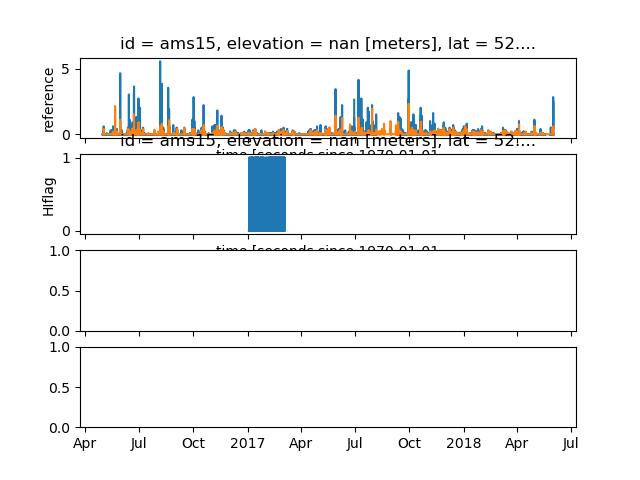

In [51]:
id = 'ams15'

fig, axs = plt.subplots(4, 1, sharex=True)

ds_pws.rainfall.sel(id=id).plot(ax=axs[0])
ds_pws.reference.sel(id=id).plot(ax=axs[0])
#ds_pws.reference.plot(ax=axs[0])

condition1.sel(id=id, time=slice("2017-01-03 00:00:00", "2017-03-04 00:00")).plot(ax=axs[1])
#condition2.sel(id=id, time=slice("2017-01-03 00:00:00", "2017-01-04 00:00")).plot(ax=axs[2])
#condition3.sel(id=id, time=slice("2017-01-03 00:00:00", "2017-01-04 00:00")).plot(ax=axs[3])

#ds_pws.sel(id="ams1").rainfall.median(dim="id").plot(label="median of neighbors")

In [38]:
condition1.sel(id=id).plot(ax=axs[1])
condition2.sel(id=id).plot(ax=ax[1])
condition3.sel(id=id).plot(ax=ax[1])


NameError: name 'ax' is not defined

In [58]:
axs

array([<Axes: >, <Axes: >], dtype=object)

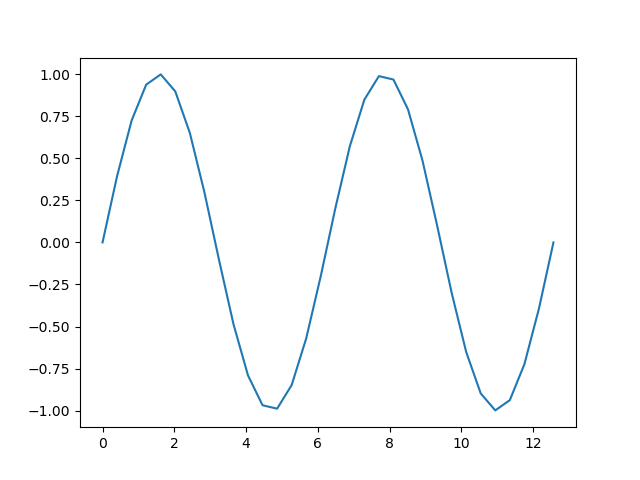

In [43]:
%matplotlib widget
x = np.linspace(0,4*np.pi,32)
y = np.sin(x)

fig,ax = plt.subplots()
ax.plot(x,y)

In [ ]:
for i in np.arange(np.shape(pws_data)[0]):
    condition1 = (reference < HIthresA) & (pws_data[:, i] > HIthresB)
    condition2 = (reference >= HIthresA) & (
        pws_data[:, i] > HIthresB / HIthresA * reference
    )
    HIflag[xr.where(condition1 | condition2)] = 1

xr.where(condition1 & (condition2 | condition3))

## Station Outlier filter

In [21]:
# ...
xr.where(ds_pws.HIflag != -1, 0, -1)

<xarray.DataArray 'HIflag' (id: 134, time: 219168)>
array([[ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    lat        (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    lon        (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06

## Bias calculation 

In [ ]:
# ...

In [ ]:
from matplotlib.widgets import Button

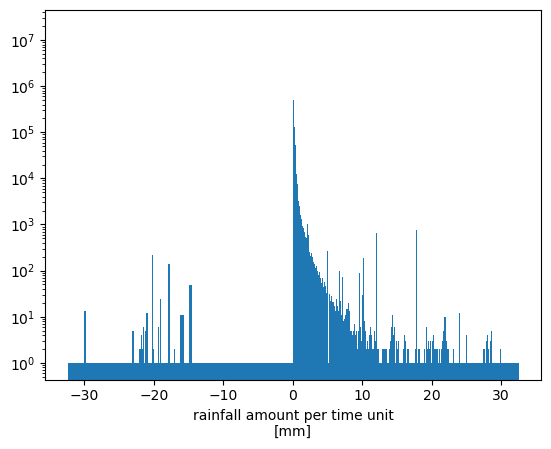

In [3]:
round = 1 #set level of accuracy
ds_pws.rainfall.round(1).plot.hist(bins=np.unique(ds_pws.rainfall.round(1)));
plt.yscale('log')

In [8]:
hej = np.sum(np.array(ds_pws.rainfall) < 0, axis=0)

In [10]:
np.sum(hej) #nr of neg values

713

In [12]:
np.unique(ds_pws.rainfall.round(1))

array([-32.4, -31.9, -31.5, -31. , -30.8, -30.6, -30. , -29.7, -29.3,
       -28.9, -28.3, -28. , -26.9, -26.4, -26. , -25.8, -25.5, -25.2,
       -24.8, -24.4, -23.2, -23.1, -22.9, -22.6, -22.5, -22.4, -22.1,
       -22. , -21.9, -21.7, -21.6, -21.5, -21.4, -21.3, -21.2, -21.1,
       -20.9, -20.8, -20.6, -20.4, -20.3, -20.1, -20. , -19.7, -19.5,
       -19.4, -19.2, -19.1, -19. , -18.9, -18.8, -18.7, -18.4, -18.3,
       -18.2, -18.1, -18. , -17.9, -17.7, -17.5, -17.3, -17.2, -17.1,
       -17. , -16.9, -16.6, -16.5, -16.3, -15.6, -14.9, -14.5, -11.6,
        -9.4,   0. ,   0.1,   0.2,   0.3,   0.4,   0.5,   0.6,   0.7,
         0.8,   0.9,   1. ,   1.1,   1.2,   1.3,   1.4,   1.5,   1.6,
         1.7,   1.8,   1.9,   2. ,   2.1,   2.2,   2.3,   2.4,   2.5,
         2.6,   2.7,   2.8,   2.9,   3. ,   3.1,   3.2,   3.3,   3.4,
         3.5,   3.6,   3.7,   3.8,   3.9,   4. ,   4.1,   4.2,   4.3,
         4.4,   4.5,   4.6,   4.7,   4.8,   4.9,   5. ,   5.1,   5.2,
         5.3,   5.4,

In [ ]:
FZflag = xr.zeros_like(ds_pws, dtype='bool')
FZflag = FZflag.rename_vars({"rainfall": "FZflag"})
FZflag

In [ ]:
HIflag = xr.zeros_like(ds_pws, dtype='bool')
HIflag = HIflag.rename_vars({"rainfall": "HIflag"})
HIflag #perhaps not smart. Now float32, should be integer

### _Checking median behaviour_

In [ ]:
#rain for certain timestep 
#ds_pws.sel(id=neighbor_ids, time="2017-09-13 00:10:00").rainfall.round(round)
mediantest = ds_pws.sel(time="2017-09-13 01:30:00").rainfall.round(1)
mediantest

In [ ]:
#ds_pws.sel(id=neighbor_ids, time="2017-09-13 00:10:00").rainfall

#median = mediantest.sel(id=neighbor_ids, time="2017-09-13 00:10:00").rainfall.median(dim="id")
median = mediantest.sel(id=neighbor_ids).median(dim="id")
median.data

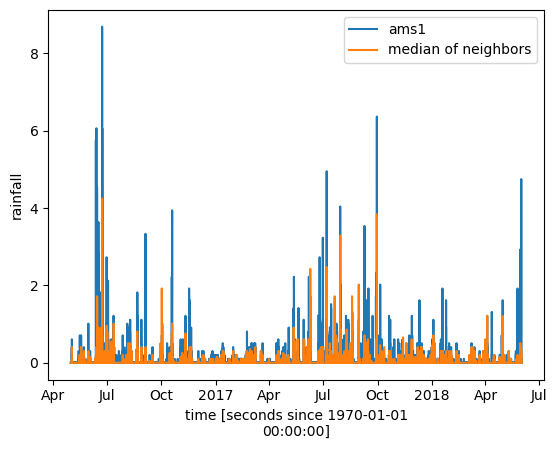

In [10]:
ds_pws.sel(id=pws_id).rainfall.plot(label="ams1")
ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id").plot(label="median of neighbors")

plt.legend();

In [15]:
ds_pws.reference.sel(time="2017-09-13 01:30:00")

<xarray.DataArray 'reference' (id: 134)> Size: 536B
array([0.101     , 0.101     , 0.101     , 0.101     , 0.101     ,
       0.101     , 0.101     , 0.101     , 0.101     , 0.11700001,
       0.11700001, 0.11700001, 0.109     , 0.101     , 0.109     ,
       0.101     , 0.101     , 0.101     , 0.101     , 0.1595    ,
       0.202     , 0.202     , 0.109     , 0.11700001, 0.202     ,
       0.101     , 0.202     , 0.202     , 0.202     , 0.202     ,
       0.202     , 0.202     , 0.202     , 0.101     , 0.101     ,
       0.1595    , 0.202     , 0.202     , 0.202     , 0.202     ,
       0.202     , 0.202     , 0.202     , 0.202     , 0.202     ,
       0.202     , 0.202     , 0.202     , 0.202     , 0.202     ,
       0.202     , 0.202     , 0.202     , 0.202     , 0.202     ,
       0.202     , 0.202     , 0.202     , 0.202     , 0.202     ,
       0.202     , 0.202     , 0.202     , 0.202     , 0.202     ,
       0.202     , 0.202     , 0.202     , 0.202     , 0.202     ,
       0.202     , 0.202     , 0.202     , 0.202     , 0.202     ,
       0.202     , 0.202     , 0.202     , 0.202     , 0.202     ,
       0.202     , 0.303     , 0.202     , 0.202     , 0.202     ,
       0.202     , 0.202     , 0.303     , 0.202     , 0.202     ,
       0.202     , 0.202     , 0.202     , 0.202     , 0.202     ,
       0.202     , 0.202     , 0.202     , 0.202     , 0.303     ,
       0.202     , 0.202     , 0.202     , 0.202     , 0.202     ,
       0.202     , 0.202     , 0.303     , 0.202     , 0.202     ,
       0.202     , 0.202     , 0.202     , 0.202     , 0.202     ,
       0.202     , 0.303     , 0.202     , 0.202     , 0.289     ,
       0.202     , 0.202     , 0.202     , 0.202     , 0.202     ,
       0.289     , 0.202     , 0.303     , 0.202     , 0.303     ,
       0.303     , 0.303     , 0.202     , 0.303     ], dtype=float32)
Coordinates:
    time       datetime64[ns] 8B 2017-09-13T01:30:00
  * id         (id) <U6 3kB 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 2kB 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    lat        (id) float64 1kB 52.31 52.3 52.31 52.35 ... 52.43 52.3 52.26
    lon        (id) float64 1kB 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
    x          (id) float64 1kB 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 1kB 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06